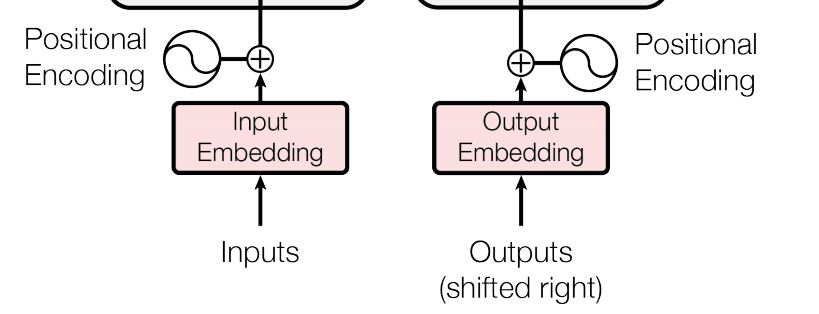

**The first step to a transformer is to add encodings, embeddings to a text, we perform postional encodings to texts before feeding into the encoder.**

In [116]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd 
import os
import torch
import math
import csv
from string import punctuation
import nltk
from textblob import TextBlob
from nltk.tokenize import sent_tokenize, word_tokenize 
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
dprint=0 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [117]:
# BASIC PRE PROCESSING
def basic_PreProcessing(sentence):
    # sentence is a single sentence
    removed_punctuation = ''.join([c for c in sentence if c not in punctuation]) # text is string
    
    lower = removed_punctuation.lower()
    words = lower.split()
    stop_words = set(stopwords.words("english"))  
    remove_stopwords = [word for word in words if word not in stop_words]

    sentence = " ".join(remove_stopwords)
    return sentence


def correct_spelling(incorrect_text):
    textBlb = TextBlob(incorrect_text)
    return textBlb.correct().string    



# READ ROWS AND PRE PROCESSING
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            # each row is a list with 3 elements(same as number of columns)
            labels.append(row[2])
            sentence = row[1] # string
            sentence = basic_PreProcessing(sentence)
            sentences.append(sentence)

    return sentences, labels  

In [118]:
sentences, labels = parse_data_from_file("/content/BBC News Train.csv")  

## INPUT EMBEDDING

In [119]:
data = [] 
for i in sentences:
    temp = []
    for j in word_tokenize(i):
        temp.append(j)
    data.append(temp)

In [120]:
sentences[0]

'worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant 2002 warnings led collapse firm following discovery 11bn £57bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early 2001 2002 said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness

In [121]:
!pip install gensim==3.8.3

In [122]:
import gensim 
from gensim.models import Word2Vec 
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings 

In [123]:
model = gensim.models.Word2Vec(data, min_count = 1, size = 512,window = 5, sg = 1)

In [124]:
model

In [125]:
word1='fraud'
word2='jury'
vector1 = model[word1]
vector2 = model[word2]
pos1=2
pos2=10

In [126]:
print(vector1)

[ 2.20193323e-02  2.06194092e-02 -1.09184310e-01 -3.15377563e-02
  1.88007243e-02  2.15479098e-02  4.24750261e-02  1.33750305e-01
 -1.26047945e-03 -2.32497528e-02  7.64393955e-02 -7.58363232e-02
 -1.36334628e-01 -1.04279378e-02 -6.47004321e-03 -9.83487964e-02
 -1.01645701e-01 -5.83983399e-02 -9.58823711e-02  3.01675983e-02
 -2.50342824e-02  7.83510730e-02 -1.38505444e-01 -7.18127843e-03
  1.45118341e-01 -1.06278755e-01  1.50974281e-03 -1.05294116e-01
 -7.85503685e-02 -1.28418416e-01  5.02170287e-02 -9.67834741e-02
 -1.63777336e-01  6.22658841e-02 -3.85045260e-02 -5.20853139e-02
 -6.90123886e-02 -2.66135074e-02 -1.19292142e-03 -5.60811833e-02
 -3.25785726e-02  1.56956360e-01  1.44802555e-01 -1.51248515e-01
  9.32005569e-02  1.81576043e-01  4.33632880e-02 -6.74208775e-02
  5.27665913e-02 -4.08876985e-02 -1.00711584e-01 -1.33541822e-01
 -2.19549760e-02 -2.53035516e-01  7.00275227e-02  1.12648346e-01
  4.10903431e-02 -5.11166453e-02 -6.72682226e-02 -9.58415717e-02
 -5.20709390e-03  1.09016

In [127]:
vector1.shape

(512,)

## Positional Encoding

A Positional Encoding example using one line of basic Python using a few lines of code for the sine and cosine functions. I added a Pytorch method inspired by Pytorch.org to explore these methods. The main idea to keep in mind is that we are looking to add small values to the word embedding output so that the positions are taken into account. This means that as long as the cosine similarity, for example, displayed at the end of the notebook, shows the positions have been taken into account, the method can apply. Depending on the Transformer model, this method can be fine-tuned as well as using other methods.

In [128]:
# compute cosine similarity
dot = np.dot(vector1, vector2)
norma = np.linalg.norm(vector1)
normb = np.linalg.norm(vector2)
cos = dot / (norma * normb)
print(dot)

2.9118805


In [129]:
print(norma,normb)

2.306947 1.5936486


In [130]:
print(cos)

0.7920332


In [131]:
aa = vector1.reshape(1,512) 
ba = vector2.reshape(1,512)
cos_lib = cosine_similarity(aa, ba)

print(vector1.shape)
print(aa.shape)

(512,)
(1, 512)


In [132]:
pe1=aa.copy()
pe2=aa.copy()
pe3=aa.copy()
paa=aa.copy()
pba=ba.copy()
d_model=512
max_print=d_model
max_length=20

pe1.shape

(1, 512)

In [133]:
for i in range(0, max_print,2):
                pe1[0][i] = math.sin(pos1 / (10000 ** ((2 * i)/d_model)))
                paa[0][i] = (paa[0][i]*math.sqrt(d_model))+ pe1[0][i]
                pe1[0][i+1] = math.cos(pos1 / (10000 ** ((2 * i)/d_model)))
                paa[0][i+1] = (paa[0][i+1]*math.sqrt(d_model))+pe1[0][i+1]
                if dprint==1:
                        print(i,pe1[0][i],i+1,pe1[0][i+1])
                        print(i,paa[0][i],i+1,paa[0][i+1])
                        print("\n")

In [134]:
print(pe1)

[[ 9.09297407e-01 -4.16146845e-01  9.58144367e-01 -2.86285430e-01
   9.87046242e-01 -1.60435960e-01  9.99164224e-01 -4.08766568e-02
   9.97479975e-01  7.09482506e-02  9.84703004e-01  1.74241230e-01
   9.63226616e-01  2.68690288e-01  9.35118318e-01  3.54335666e-01
   9.02130723e-01  4.31462824e-01  8.65725577e-01  5.00518918e-01
   8.27103794e-01  5.62049210e-01  7.87237823e-01  6.16649508e-01
   7.46903539e-01  6.64932430e-01  7.06710517e-01  7.07502782e-01
   6.67129099e-01  7.44942129e-01  6.28514349e-01  7.77797997e-01
   5.91127098e-01  8.06578398e-01  5.55151761e-01  8.31749082e-01
   5.20711303e-01  8.53732824e-01  4.87879932e-01  8.72910738e-01
   4.56693351e-01  8.89624178e-01  4.27157611e-01  9.04177189e-01
   3.99255812e-01  9.16839600e-01  3.72953892e-01  9.27849889e-01
   3.48205268e-01  9.37418282e-01  3.24954301e-01  9.45729733e-01
   3.03139359e-01  9.52946246e-01  2.82694966e-01  9.59209859e-01
   2.63553679e-01  9.64644730e-01  2.45647445e-01  9.69359219e-01
   2.28908

In [135]:
pe1.shape

(1, 512)

In [136]:
# A  method in Pytorch using torch.exp and math.log :
max_len=max_length                
pe = torch.zeros(max_len, d_model)
print(pe.shape)

position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
print(position.shape)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
print(pe[:, 0::2])

torch.Size([20, 512])
torch.Size([20, 1])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  8.2186e-01,  8.0196e-01,  ...,  1.1140e-04,
          1.0746e-04,  1.0366e-04],
        [ 9.0930e-01,  9.3641e-01,  9.5814e-01,  ...,  2.2279e-04,
          2.1492e-04,  2.0733e-04],
        ...,
        [-9.6140e-01, -6.3753e-01, -1.1153e-01,  ...,  1.8938e-03,
          1.8268e-03,  1.7623e-03],
        [-7.5099e-01, -9.9638e-01, -8.6358e-01,  ...,  2.0052e-03,
          1.9343e-03,  1.8659e-03],
        [ 1.4988e-01, -4.9773e-01, -9.2024e-01,  ...,  2.1165e-03,
          2.0418e-03,  1.9696e-03]])


In [137]:
for i in range(0, max_print,2):
                pe2[0][i] = math.sin(pos2 / (10000 ** ((2 * i)/d_model)))
                pba[0][i] = (pba[0][i]*math.sqrt(d_model))+ pe2[0][i]
            
                pe2[0][i+1] = math.cos(pos2 / (10000 ** ((2 * i)/d_model)))
                pba[0][i+1] = (pba[0][i+1]*math.sqrt(d_model))+ pe2[0][i+1]
               
                if dprint==1:
                        print(i,pe2[0][i],i+1,pe2[0][i+1])
                        print(i,paa[0][i],i+1,paa[0][i+1])
                        print("\n")

print(word1,word2)
cos_lib = cosine_similarity(aa, ba)
print(cos_lib,"word similarity")
cos_lib = cosine_similarity(pe1, pe2)
print(cos_lib,"positional similarity")
cos_lib = cosine_similarity(paa, pba)
print(cos_lib,"positional encoding similarity")

if dprint==1:
        print(word1)
        print("embedding")
        print(aa)
        print("positional encoding")
        print(pe1)
        print("encoded embedding")
        print(paa)

        print(word2)
        print("embedding")
        print(ba)
        print("positional encoding")
        print(pe2)
        print("encoded embedding")
        print(pba)

fraud jury
[[0.7920331]] word similarity
[[0.8600013]] positional similarity
[[0.79040456]] positional encoding similarity
